In [1]:
import pandas as pd
import numpy as np
import scipy as scp
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
DATAPATH='data/'

In [3]:
data = pd.read_csv(DATAPATH+'cleaned_unique_index.csv',low_memory=False)

In [4]:
data.set_index('code',inplace =True)

In [5]:
data=data.sample(int(len(data) * .1))

In [6]:
data_labels=data.labels_en.dropna().str.split(',')
data_labels_exploded=data_labels.apply(pd.Series).unstack().dropna()

In [7]:
data_categories=data.categories_en.dropna().str.split(',')
data_categories_exploded=data_categories.apply(pd.Series).unstack().dropna()

In [8]:
data_categories_exploded.head()

   code         
0  3263859912215                           Desserts
   3222471911433                       Frozen foods
   5410803560451                          Groceries
   3564709001777                              Meats
   3564707108348    Plant-based foods and beverages
dtype: object

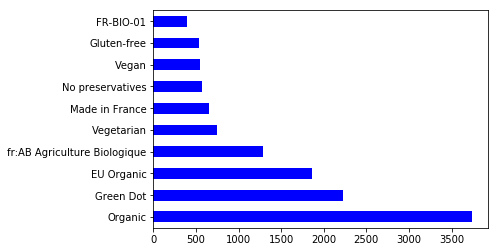

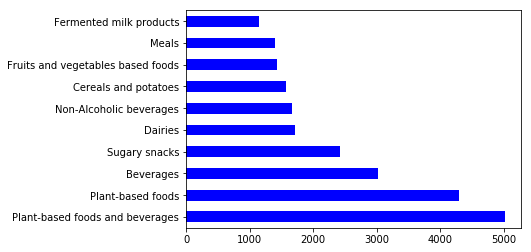

In [9]:
data_labels_exploded.value_counts().head(10).plot(kind='barh',color='b')
plt.show()
data_categories_exploded.value_counts().head(10).plot(kind='barh',color='b')
plt.show()

In [10]:
z=pd.DataFrame(data_labels_exploded).reset_index().set_index("code")[[0]]
z.columns=['label']
x=pd.DataFrame(data_categories_exploded).reset_index().set_index('code')[[0]]
x.columns=['category']

In [11]:
f=x.join(z).dropna()

In [83]:
f['joined']=f['category']+','+f['label']

In [58]:
highest_support=pd.Series(f['joined'].value_counts().head(50).index.values)

In [78]:
grouped_=list(zip(*(highest_support.str.split(',').values)))
highest_categories=np.unique(list(grouped_[0]))
highest_labels=np.unique(list(grouped_[1]))
highest_categories=highest_categories.tolist()
highest_labels=highest_labels.tolist()


# Local Rule Analysis

In [84]:
support=f['joined'].value_counts()
label_counts=f['label'].value_counts()
category_counts=f['category'].value_counts()
category_counts.loc['Beverages']

3520

In [91]:
local_rules={}
i=0
for label in highest_labels:

    for category in highest_categories:
        i+=1
        
        string_=category+','+label
        if string_ in support.index:
            local_rules[label+' -> '+category]=support.loc[category+','+label]/label_counts.loc[label]
            local_rules[category+' -> '+label]=support.loc[category+','+label]/category_counts.loc[category]
        else:
            local_rules[label+' -> '+category]=0.
            local_rules[category+' -> '+label]=0.
        

In [85]:
support.index

Index(['Plant-based foods and beverages,Organic', 'Plant-based foods,Organic',
       'Plant-based foods and beverages,EU Organic',
       'Plant-based foods,EU Organic',
       'Plant-based foods and beverages,Green Dot',
       'Plant-based foods and beverages,fr:AB Agriculture Biologique',
       'Plant-based foods,Green Dot',
       'Plant-based foods,fr:AB Agriculture Biologique', 'Beverages,Organic',
       'Plant-based foods and beverages,Vegetarian',
       ...
       'Peanuts,fr:Qualite-controlee', 'Smoked salmons,fr:Decongele',
       'Spreads,fr:Deconseille-aux-enfants-de-moins-de-1-an',
       'Candies,de:In-blindenschrift', 'Pizzas,EU Organic',
       'Fruits based foods,fr:Concours général agricole',
       'de:Zitronensaft,DE-ÖKO-007', 'Biscuits,Kosher-parve',
       'Fermented foods,GB-ORG-05',
       'fr:Gateaux-aux-amandes,fr:Saveurs de l'Année 2015'],
      dtype='object', length=47699)

In [31]:
for elm in f['label'].head():
    print(elm)

Green Dot
fr:Déconseillé aux femmes enceintes
Green Dot
fr:Déconseillé aux femmes enceintes
Green Dot


In [40]:
len(f['label'])*len(f['category'])

23036864841

In [92]:
local_rules

{'Alcoholic beverages -> EU Organic': 0.0504950495049505,
 'Alcoholic beverages -> FR-BIO-01': 0.01485148514851485,
 'Alcoholic beverages -> Gluten-free': 0.0029702970297029703,
 'Alcoholic beverages -> Green Dot': 0.08811881188118811,
 'Alcoholic beverages -> No preservatives': 0.0009900990099009901,
 'Alcoholic beverages -> Not advised for pregnant women': 0.1792079207920792,
 'Alcoholic beverages -> Not advised for specific people': 0.18118811881188118,
 'Alcoholic beverages -> Organic': 0.053465346534653464,
 'Alcoholic beverages -> Vegan': 0.0049504950495049506,
 'Alcoholic beverages -> Vegetarian': 0.005940594059405941,
 'Alcoholic beverages -> fr:AB Agriculture Biologique': 0.026732673267326732,
 'Alcoholic beverages -> fr:Viande Française': 0.0,
 'Beverages -> EU Organic': 0.0659090909090909,
 'Beverages -> FR-BIO-01': 0.017329545454545455,
 'Beverages -> Gluten-free': 0.008238636363636363,
 'Beverages -> Green Dot': 0.07897727272727273,
 'Beverages -> No preservatives': 0.0201